# Lunar Lander with Deep Q-Learning


This notebook implements the [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) from OpenAI's Gym with Pytorch. The goal is to land the lander safely in the landing pad.

**Introduction of the project:**

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

**Acknowledgement:**<br>
- The lunar lander environment set up comes from [OpenAI' Gym](https://gym.openai.com/).
- The `rl_glue` set up and the idea of experimence replay come from the [Reinforcement Learning Specialization from Coursera](https://www.coursera.org/specializations/reinforcement-learning).


# Section 1: Training

## 1. Import Packages


In [6]:
# Basic packages
import os

import shutil

from collections import deque

from copy import deepcopy

from tqdm.auto import tqdm

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Lunar lander and RL-GLUE packages
from rl_glue import RLGlue
from environment import BaseEnvironment

from lunar_lander import LunarLanderEnvironment

from agent import BaseAgent

from plot_script import plot_result, draw_neural_net

# Pytorch packages
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

# Gym packages
import gym
from gym import wrappers
from time import time

## 2. Build the neural network

### 2.1 Build the network

In [7]:
class RLModel(nn.Module):
    
    def __init__(self, network_arch):
        
        super().__init__()
        self.num_states = network_arch['num_states']
        self.hidden_units = network_arch['num_hidden_units']
        self.num_actions = network_arch['num_actions']
        
        # The hidden layer
        self.fc1 = nn.Linear(in_features = self.num_states, out_features = self.hidden_units)
        
        # The output layer
        self.fc2 = nn.Linear(in_features = self.hidden_units, out_features = self.num_actions)
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        
        # No activation func, output should be a tensor(batch, num_actions)
        out = self.fc2(x)
        
        return out


### 2.2 Instantiate the model

Create a model with the following archiecture:
- Number of input units (states): 8
- Number of hidden units: 20
- Number of output units (actions): 3

In [8]:
# network_arch = {
#     'num_states' : 8,
#     'num_hidden_units': 20,
#     'num_actions':3
    
# }

# model = RLModel(network_arch)

# model


Visualize the neural network:

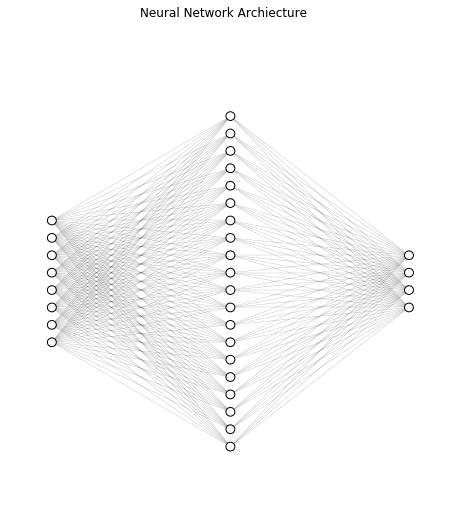

In [9]:
fig = plt.figure(figsize = (8,8))
fig.suptitle('Neural Network Archiecture')
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [8, 20, 4])


## 3. Define loss and optimizer

### 3.1 Optimizer

Here we use Adam optimization.

In [10]:
# Set the learning rate
learning_rate = 0.001

# We will instantiate the optimizer in the agent class.
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = [0.99, 0.999], eps = 1e-04)

### 3.2 Loss

In [11]:
criterion = nn.MSELoss()

## 4. Create the buffer

Create a buffer to implement experience replay. 

In [12]:
class Buffer:
    
    def __init__(self, batch_size, buffer_size, seed):
        
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.rand_generator = np.random.RandomState(seed)
        
        self.buffer = []
        
        
    def append(self, state, action, terminal, reward, next_state):
        """
        Append the next experience.
        
        Args:
            state: the state (torch tensor).
            action: the action (integer).
            terminal: 1 if the next state is the terminal, 0 otherwise.
        
        """
        # delete the first experience if the size is reaching the maximum
        if len(self.buffer) == self.buffer_size:
            del self.buffer[0]
            
        self.buffer.append((torch.tensor(state), torch.tensor(action), torch.tensor(terminal), torch.tensor(reward).float(), torch.tensor(next_state)))
        
    def sample(self):
        """
        Sample from the buffer and return the virtual experience.
        
        Args:
            None
        Returns:
            A list of transition tuples (state, action, terminal, reward, next_state), list length: batch_size
        """
        
        indexs = self.rand_generator.choice(len(self.buffer), size = self.batch_size)
        
        transitions = [self.buffer[idx] for idx in indexs]
        
        return transitions
       
    def get_buffer(self):
        """
        Return the current buffer
        """
        return self.buffer
        
        

## 5. Create the agent

### 5.1 Softmax policy

The probability of selecting each action:

$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau - max_{c}Q(s, c)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau - max_{c}Q(s, c)/\tau}}$$

Where:<br>
$Q(s, a)$: The action value.<br>
$tau$: The temperature parameter.

In [13]:
def softmax(action_values, tau = 1.0):
    
    """
    Args:
        action_values: A torch tensor (2d) of size (batch_size, num_actions).
        tau: Tempearture parameter.
    
    Returns:
        probs: A torch tensor of size (batch_size, num_actions). The value represents the probability of select 
        that action.
    """
    
    max_action_value = torch.max(action_values, axis = 1, keepdim = True)[0]/tau
    action_values = action_values/tau
    
    preference = action_values - max_action_value
    
    exp_action = torch.exp(preference)
    sum_exp_action = torch.sum(exp_action, axis = 1).view(-1,1)


    probs = exp_action/sum_exp_action

    
    return probs



### 5.2 Neural network training function

Create a function to perform one step update: Calculate the TD-error, and do the backpropagation once. We can choose the reinforcement learning algorithms to train the agent. By default, we are using the Q-Learning.

In [14]:
def train_network(experiences, model, current_model, optimizer, criterion, discount, tau):
    
    """
    Calculate the TD-error and update the network
    
    """
    optimizer.zero_grad()
    
    states, actions, terminals, rewards, next_states = map(list, zip(*experiences))
    
    
#     print(next_states)
    q_next = current_model(Variable(torch.stack(next_states))).squeeze()
    probs = softmax(q_next, tau)

    # calculate the maximum action value of next states
#     expected_q_next = (1-torch.stack(terminals)) * (torch.sum(probs * q_next , axis = 1))
    max_q_next = (1-torch.stack(terminals)) * (torch.max(q_next , axis = 1)[0])
    # calculate the targets
    
    rewards = torch.stack(rewards).float()
#     targets = Variable(rewards + (discount * expected_q_next)).float()
    targets = Variable(rewards + (discount * max_q_next)).float()
    
    # calculate the outputs from the previous states (batch_size, num_actions)
    outputs = model(Variable(torch.stack(states).float())).squeeze()
    

    actions = torch.stack(actions).view(-1,1)
    
    outputs = torch.gather(outputs, 1, actions).squeeze()
    
    # the loss
    loss = criterion(outputs, targets)
    
    loss.backward()
    
    # update
    optimizer.step()

### 5.3 Create the agent

Create the agent class.


In [15]:
class Agent(BaseAgent):
    
    def __init__(self):
        self.name = 'Lunar Lander Expected Sarsa Agent'
        
    def agent_init(self, agent_config):
        
        """
        Called when the experiment first starts.
        Args:
            agent_config: Python dict contains:
                        {
                        network_arch: dict,
                        batch_size: integer,
                        buffer_size: integer,
                        gamma: float,
                        learning_rate: float,
                        tau: float,
                        seed:integer,
                        num_replay_updates: float
                        
                        
                        }
        
        """
        # The model
        self.model = RLModel(agent_config['network_arch'])
        # The replay buffer
        self.buffer = Buffer(agent_config['batch_size'],
                            agent_config['buffer_size'],
                            agent_config['seed'])
        # The optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), 
                                          lr = agent_config['learning_rate'], 
                                          betas = [0.99,0.999], 
                                          eps = 1e-04)
        # The loss
        self.criterion = nn.MSELoss()
        
        self.batch_size = agent_config['batch_size']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        self.num_replay = agent_config['num_replay_updates']
        self.num_actions = agent_config['network_arch']['num_actions']
        # random number generator
        self.rand_generator = np.random.RandomState(agent_config['seed'])
        
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0
        
    def policy(self, state):
        
        """
        Select the action given a single state.
        
        """
        # compute action values states:(1, state_dim)
        q_values = self.model(state)

        # compute the probs of each action (1, num_actions)
        probs = softmax(q_values.data, self.tau)
        probs = np.array(probs)
        probs /= probs.sum()

        # select action
        action = self.rand_generator.choice(self.num_actions, 1, p = probs.squeeze())
        
        return action
    
    
    def agent_start(self, state):
        """
        Called when the experiments starts, after the env starts.
        
        Args:
            state: pytorch tensor.
            
        Returns:
            action: The first action.
        """
        
        self.sum_rewards = 0
        self.episode_steps = 0
        
        state = torch.tensor([state]).view(1, -1)

        action = self.policy(state)
        
        self.last_state = state
        self.last_action = int(action)
        
        return self.last_action
    
    def agent_step(self, reward, state):
        
        """
        The agent takes one step.
        
        Args:
            reward: The reward the agent received, float.
            state: The next state the agent received, Numpy array.
            
        Returns:
            action: The action the agent is taking, integer.
        
        """
        ### Add another step and reward
        self.episode_steps += 1
        self.sum_rewards += reward
        
        ### Select action
        state = torch.tensor([state])
        
        action = self.policy(state)
        
        ### Append new experience to the buffer
        self.buffer.append(self.last_state, self.last_action, 0, reward, state)
        
        ### Replay steps:
        # replay only if the buffer size is large enough
        if len(self.buffer.get_buffer()) >= self.batch_size:
            # copy the current network
            current_model = deepcopy(self.model)
            
            # replay steps:
            for i in range(self.num_replay):
                
                # sample experiences from the buffer
                experiences = self.buffer.sample()
                
                # train the network
                train_network(experiences, self.model, current_model, self.optimizer, self.criterion, self.discount, self.tau)
                
        ### Update the last state and action
        self.last_state = state
        self.last_action = int(action)
        
        return self.last_action
    
    def agent_end(self, reward):
        
        """
        Called when the agent terminates.
        
        Args:
            reward: The reward the agent received for the termination.
        
        """
        self.episode_steps += 1
        self.sum_rewards += reward
        
        ### Find the final state
        state = torch.zeros_like(self.last_state)
        
        ### Append new experience to the buffer
        self.buffer.append(self.last_state, self.last_action, 1, reward, state)
        
        
        ### Replay steps:
        # replay only if the buffer size is large enough
        if len(self.buffer.get_buffer()) >= self.batch_size:
            # copy the current network
            current_model = deepcopy(self.model)
            
            # replay steps:
            for i in range(self.num_replay):
                
                # sample experiences from the buffer
                experiences = self.buffer.sample()
                
                # train the network
                train_network(experiences, self.model, current_model, self.optimizer, self.criterion, self.discount, self.tau)

        ### Save the model at each episode
        
#         torch.save(self.model, 'new_results/current_nodel.pth')
    def agent_message(self, message):
        
        """
        Return the given agent message.
        
        Args:
            message: String 
        
       """
        if message == 'get_sum_reward':
            
            return self.sum_rewards
        else:
            raise Exception('No given message of the agent!')
    

        

## 8. Run experiments



### 8.1 Experiment function

Create a function to run the experiment.

In [16]:
### A func to run the experiment

def run_experiment(environment, agent, environment_configs, agent_configs, experiment_configs, finetune, PATH = 'new_results/current_model_700.pth'):
    
    """
    Run the experiment.
    
    Args:
        envierment: The environment class.
        agent: The agent class.
        environment_configs: environment parameters (Python dict).
        agent_configs agent parameters (Python dict).
        {
        
        
        }

        experiment_configs: experiment parameters (Python dict)
        {'num_runs': Integer. Number of runs of the experiment,
        'num_episodes': Integer. Number of episodes of the experiment,
        'timeout': Integer. Time step limit of the experiment.
        }
        
        finetune: boolean. Finetune or train from scratch.
    Returns:
        agent_sum_reward: Numpy array(num_runs, num_episodes), the sum reward received by the agent.
    
    """
    
    ### Instantiate the RLGlue class
    rl_glue = RLGlue(environment, agent)
    
    ### Save sum of reward
    agent_sum_reward = np.zeros((experiment_configs['num_runs'],experiment_configs['num_episodes']))
    
    ### Loop over runs
    for run in tqdm(range(experiment_configs['num_runs'])):
        
        # Set the random seed for agent and environment
        agent_configs['seed'] = run
        environment_configs['seed'] = run
        
        # Initialize the rl_glue
        rl_glue.rl_init(agent_configs, environment_configs)
        
        # Finetuning
        if finetune:
            
            checkpoint = torch.load(PATH)
            rl_glue.agent.model.load_state_dict(checkpoint['model_state_dict'])

            start_episode = checkpoint['episode'] + 1
            
            print('Finetuning...')
        else:
            start_episode = 0
            print('Training...')
        
        ### Loop over episodes
        for episode in tqdm(range(start_episode, start_episode + experiment_configs['num_episodes'])):
            # Run episode
            rl_glue.rl_episode(experiment_configs['timeout'])
            
            # Get reward
            episode_reward = rl_glue.rl_agent_message('get_sum_reward')
            
            # Save the reward in the array
            agent_sum_reward[run, episode - start_episode] = episode_reward
            
            # Save the model for testing
            if episode == start_episode + experiment_configs['num_episodes'] - 1:
                
                current_model = rl_glue.agent.model
                torch.save({'episode':episode,
                'model_state_dict':current_model.state_dict(),
                            },
                'new_results2/current_model_{}.pth'.format(episode+1))
                
            print('Run:{}, episode:{}, reward:{}'.format(run, episode, episode_reward))
            
    return agent_sum_reward
    

### 8.2 Plot functions

Create helper functions to draw the results.

In [17]:
def plot_reward(rewards, title, starting_episode = 0):
    """Plot the reward of each episode.
    """
    
    rewards = np.mean(rewards, axis = 0).squeeze()
    episodes = np.arange(starting_episode, starting_episode + rewards.shape[0], 1)
    
    plt.figure(figsize = (20,10))
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Reward of each episode')
    plt.plot(episodes, rewards)
    plt.show()
    
    return


def smooth(data, k):
    """
    Smooth the data with moving average.
    
    """
    num_episodes = data.shape[1]
    num_runs = data.shape[0]

    smoothed_data = np.zeros((num_runs, num_episodes))

    for i in range(num_episodes):
        if i < k:
            smoothed_data[:, i] = np.mean(data[:, :i+1], axis = 1)   
        else:
            smoothed_data[:, i] = np.mean(data[:, i-k:i+1], axis = 1)    
        

    return smoothed_data

### 8.3 Train the agent

Define the following hyperparameters:


In [18]:

agent = Agent
environment = LunarLanderEnvironment

environment_configs = {}
agent_configs = {
    'network_arch' : {'num_states':8,
               'num_hidden_units' : 256,
               'num_actions': 4},
    
    'batch_size': 8,
    'buffer_size': 50000,
    'gamma': 0.99,
    'learning_rate': 1e-4,
    'tau':0.01 ,
    'seed':0,
    'num_replay_updates':5
      
}

experiment_configs = {
    'num_runs':1,
    'num_episodes':100,
    'timeout': 1000
}

PATH = 'new_results/current_model_700.pth'

Run the experiment and get the results. Change `finetune` to `False` to train from scratch.

In [14]:
sum_reward = run_experiment(environment, agent, environment_configs, agent_configs, experiment_configs, finetune = True)

Finetuning...


/Users/shuohan/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Run:0, episode:700, reward:-49.53612068910208
Run:0, episode:701, reward:251.2663693829415
Run:0, episode:702, reward:-16.39866134237893
Run:0, episode:703, reward:-143.75112336692575
Run:0, episode:704, reward:202.87321681012108
Run:0, episode:705, reward:218.48327754777597
Run:0, episode:706, reward:-0.721126780186095
Run:0, episode:707, reward:161.41694218572354
Run:0, episode:708, reward:232.46851950588356
Run:0, episode:709, reward:272.5306561197939
Run:0, episode:710, reward:221.94004883868394
Run:0, episode:711, reward:243.43595825439746
Run:0, episode:712, reward:278.07117057488455
Run:0, episode:713, reward:246.8263468407302
Run:0, episode:714, reward:257.79933377506666
Run:0, episode:715, reward:254.7134757117176
Run:0, episode:716, reward:267.63444289367544
Run:0, episode:717, reward:259.58122268925496
Run:0, episode:718, reward:259.39124028719664
Run:0, episode:719, reward:252.02793140768892
Run:0, episode:720, reward:258.2167299168074
Run:0, episode:721, reward:275.3773199

Plot the reward of each episode and the smoothed reward. The following two plots show the results of finetuning for 100 episodes from pretrained 700-episode model.

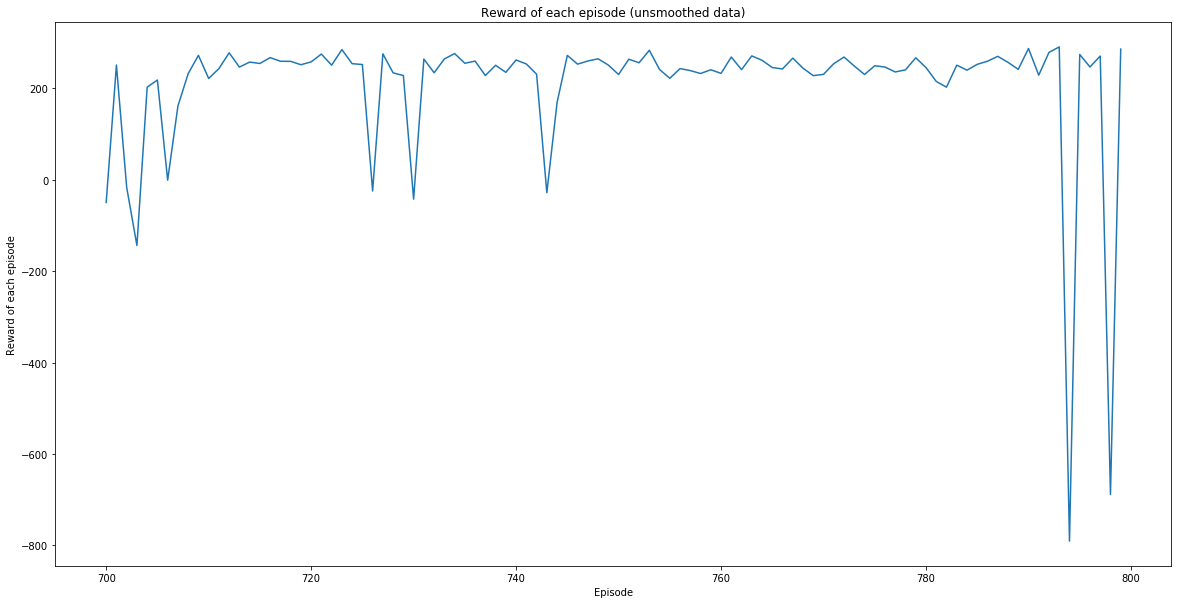

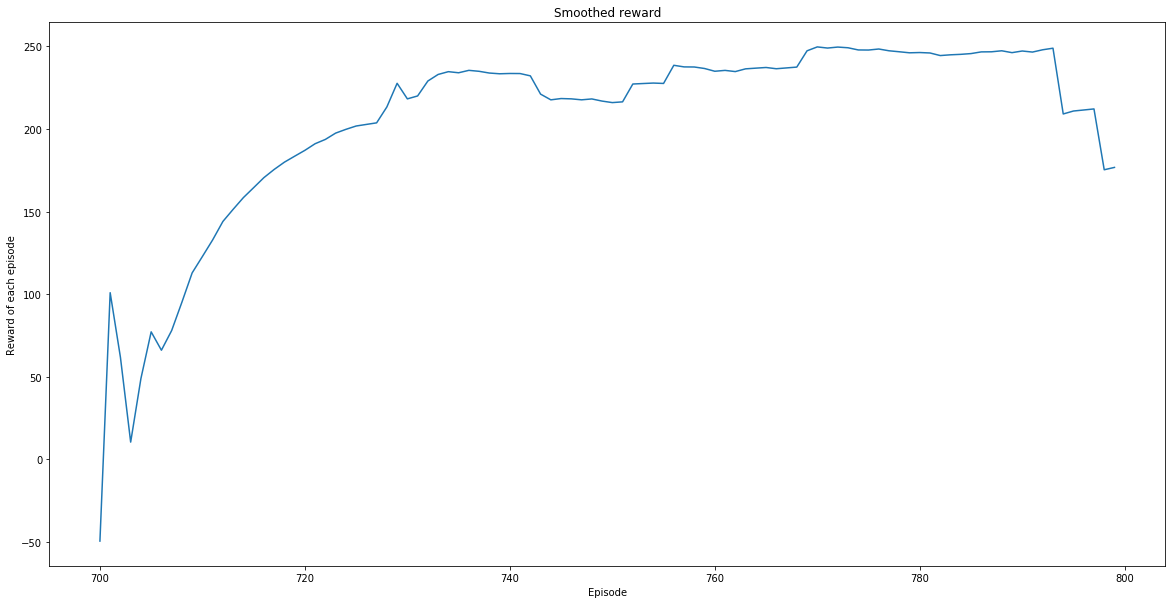

In [65]:
smoothed_reward = smooth(sum_reward, 25)


plot_reward(sum_reward, 'Reward of each episode (unsmoothed data)', 700)

plot_reward(smoothed_reward, 'Smoothed reward', 700)

# Section 2: Testing

### 9.1 Load the Model

In [22]:
model_path = 'new_results2/current_model_800.pth'
current_model = RLModel(agent_configs['network_arch'])
checkpoint = torch.load(model_path)
current_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### 9.2 Softmax policy

In [23]:
def policy(state, model, num_actions = 4):
        
        """
        Select the action given a single state.
        
        """
        model.eval()
        # compute action values states:(1, state_dim)
        q_values = model(state)

        # compute the probs of each action (1, num_actions)
        probs = softmax(q_values.data, tau = 0.01)
        probs = np.array(probs)
        probs /= probs.sum()

        # select action
        rand_generator = np.random.RandomState(seed = 1)
        action = rand_generator.choice(num_actions, 1, p = probs.squeeze())
#         action = np.argmax(probs.squeeze())
        
        return action

### 9.3 Visualize the results

In [24]:
env = gym.make("LunarLander-v2")
env = wrappers.Monitor(env, './videos_800/' + '/')
for i_episode in range(10):
    observation = env.reset()
    total_reward = 0
    
    for t in range(1000):
        env.render()
#         print(observation)
        with torch.no_grad():
            observation = Variable(torch.tensor(observation).view(1, -1))
            action = policy(observation, current_model)
            action = int(action.squeeze())

            observation, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                
                print("Episode finished after {} timesteps, total reward : {}".format(t+1, total_reward))
                break
env.close()
print('end')

Episode finished after 607 timesteps, total reward : 164.66631526615436
Episode finished after 1000 timesteps, total reward : -192.5387365035255
Episode finished after 335 timesteps, total reward : -13.426413275663776
Episode finished after 346 timesteps, total reward : 267.8301248618174
Episode finished after 836 timesteps, total reward : 168.65642626619413
Episode finished after 345 timesteps, total reward : 245.24282540288272
Episode finished after 418 timesteps, total reward : 213.4781380455811
Episode finished after 457 timesteps, total reward : 196.87590294273446
Episode finished after 477 timesteps, total reward : 208.39306969716304
Episode finished after 726 timesteps, total reward : 215.983896022225
end
